<a href="https://colab.research.google.com/github/bdemchak/cytoscape-jupyter/blob/main/gangsu/basic_protocol_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a work-in-progress reproduction of the [Biological Network Exploration with Cytoscape 3](https://pubmed.ncbi.nlm.nih.gov/25199793/) Basic Protocol 2, which imports data from the Goh/Barabasi human disease network and displays it for exploration.


---
#Setup data files, py4cytoscape and Cytoscape connection
---
**NOTE: To run this notebook, you must manually start Cytoscape first -- don't proceed until you have started Cytoscape.**

---
##Setup: Import source data files

The network files are pre-positioned in GitHub, and are downloaded here for convenience. Once downloaded into the Python file system, they are downloaded into the Cytoscape sandbox for direct access by Cytoscape.

They really should be in web locations enables them to be downloaded directly by Cytoscape via a CyREST POST v1/networks call (assuming we can get Cytoscape itself to load directly from a URL). 


In [1]:
!rm -r Barabasi
!mkdir Barabasi

!rm -r output/
!mkdir output
!ls -l 
OUTPUT_DIR = 'output/'


total 16
drwxr-xr-x 2 root root 4096 Mar 19 00:31 Barabasi
drwxr-xr-x 2 root root 4096 Mar 19 00:25 logs
drwxr-xr-x 2 root root 4096 Mar 19 00:31 output
drwxr-xr-x 1 root root 4096 Mar  5 14:37 sample_data


---
##Setup: Fetch latest py4cytoscape




**Note that you can fetch from a specific github branch by adding "@<branch>" to the "py4cytocape" at the end of the github URL.**

For example, to get branch 0.0.5: git+https://github.com/cytoscape/py4cytoscape@0.0.5

In [2]:
!pip uninstall -y py4cytoscape

#!pip install py4cytoscape
!pip install git+https://github.com/cytoscape/py4cytoscape@0.0.8
#!pip install git+https://github.com/cytoscape/py4cytoscape

Uninstalling py4cytoscape-0.0.8:
  Successfully uninstalled py4cytoscape-0.0.8
  Cloning https://github.com/cytoscape/py4cytoscape (to revision 0.0.8) to /tmp/pip-req-build-xy130_cb
  Running command git clone -q https://github.com/cytoscape/py4cytoscape /tmp/pip-req-build-xy130_cb
  Running command git checkout -b 0.0.8 --track origin/0.0.8
  Switched to a new branch '0.0.8'
  Branch '0.0.8' set up to track remote branch '0.0.8' from 'origin'.
  Created wheel for py4cytoscape: filename=py4cytoscape-0.0.8-cp37-none-any.whl size=144178 sha256=b4b0a1f697ad704054d270e69e3358001a413df5b8f17a1763e855e4daf190f2
  Stored in directory: /tmp/pip-ephem-wheel-cache-tnj4nmxc/wheels/50/fb/ad/2ef86b83249494e3b5793a114c7b3640f4c5f926fbfc9c23c8
Successfully built py4cytoscape


---
##Setup: Set up Cytoscape connection


In [3]:
import IPython
import py4cytoscape as p4c
print(f'Loading Javascript client ... {p4c.get_browser_client_channel()} on {p4c.get_jupyter_bridge_url()}')
browser_client_js = p4c.get_browser_client_js(True)
IPython.display.Javascript(browser_client_js) # Start browser client


Loading Javascript client ... f40f6696-4ab1-4e6d-9407-516d3a034254 on https://jupyter-bridge.cytoscape.org


<IPython.core.display.Javascript object>

---
#Sanity test to verify Cytoscape connection


In [4]:
p4c.cytoscape_version_info()


{'apiVersion': 'v1',
 'automationAPIVersion': '1.0.0',
 'cytoscapeVersion': '3.9.0-SNAPSHOT',
 'jupyterBridgeVersion': '0.0.2',
 'py4cytoscapeVersion': '0.0.8'}

---
# Position network files into Cytoscape's current sandbox

**Sandboxing is explained in https://py4cytoscape.readthedocs.io/en/latest/concepts.html#sandboxing**

In [6]:
barabasi = {}
barabasi['disease_net_txt'] = p4c.sandbox_url_to('https://github.com/bdemchak/cytoscape-jupyter/blob/main/gangsu/Barabasi/disease.net.txt', 'disease.net.txt')
barabasi['gene_net_txt'] = p4c.sandbox_url_to('https://github.com/bdemchak/cytoscape-jupyter/blob/main/gangsu/Barabasi/gene.net.txt', 'gene.net.txt')
barabasi['supp_tablesS2_txt'] = p4c.sandbox_url_to('https://github.com/bdemchak/cytoscape-jupyter/blob/main/gangsu/Barabasi/supplementary_tableS2.txt', 'supplementary_tableS2.txt')
barabasi['supp_tablesS3_txt'] = p4c.sandbox_url_to('https://github.com/bdemchak/cytoscape-jupyter/blob/main/gangsu/Barabasi/supplementary_tableS3.txt', 'supplementary_tableS3.txt')
barabasi['supp_tablesS4_txt'] = p4c.sandbox_url_to('https://github.com/bdemchak/cytoscape-jupyter/blob/main/gangsu/Barabasi/supplementary_tableS4.txt', 'supplementary_tableS4.txt')
print(barabasi)


{'disease_net_txt': {'filePath': 'C:\\Users\\CyDeveloper\\CytoscapeConfiguration\\filetransfer\\default_sandbox\\disease.net.txt', 'fileByteCount': 35861}, 'gene_net_txt': {'filePath': 'C:\\Users\\CyDeveloper\\CytoscapeConfiguration\\filetransfer\\default_sandbox\\gene.net.txt', 'fileByteCount': 197835}, 'supp_tablesS2_txt': {'filePath': 'C:\\Users\\CyDeveloper\\CytoscapeConfiguration\\filetransfer\\default_sandbox\\supplementary_tableS2.txt', 'fileByteCount': 97916}, 'supp_tablesS3_txt': {'filePath': 'C:\\Users\\CyDeveloper\\CytoscapeConfiguration\\filetransfer\\default_sandbox\\supplementary_tableS3.txt', 'fileByteCount': 127626}, 'supp_tablesS4_txt': {'filePath': 'C:\\Users\\CyDeveloper\\CytoscapeConfiguration\\filetransfer\\default_sandbox\\supplementary_tableS4.txt', 'fileByteCount': 557710}}



---
#Explore the protein-protein interaction network.

First, load the protein-protein network into Cytoscape.

This could take a few minutes because of the automatic force-directed layout.


In [7]:
p4c.close_session(False)
p4c.import_network_from_file('supplementary_tableS4.txt', tabular_params={'firstRowAsColumnNames': True, 'startLoadRow': 2, 'columnTypeList': 'x,s,x,t,i'})


{'networks': [40899], 'views': [129573]}

##Layout and overlay information on the network

1.   Create a different colors for the edges representing different types of interactions.
2.   Make the nodes themselves transparent so edges are easier to see.
3.   For fun, create an image of the resulting network and display it in this notebook.


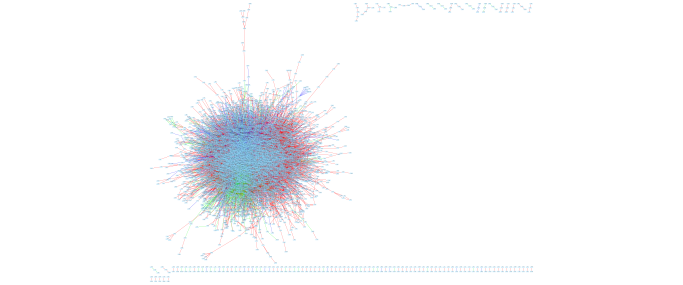

In [8]:
RED = '#ff0000'
GREEN = '#00ff00'
TEAL = '#00ffff'
PURPLE = '#ff00ff'
YELLOW = '#ffff00', 
BLUE = '#0000ff'
GREY = '#808080'

map = p4c.map_visual_property('EDGE_STROKE_UNSELECTED_PAINT', 'interaction', 'discrete', 
                              ['L', 'R', 'RL', 'RS', 'RSL', 'S', 'SL'], 
                              [RED, GREEN, TEAL, PURPLE, YELLOW, BLUE, GREY])
p4c.update_style_mapping('default', map)

p4c.set_node_fill_opacity_default(100, 'default')
p4c.toggle_graphics_details()

OUT_FILE = 'WholeNetwork.png'
p4c.export_image(OUT_FILE)
p4c.sandbox_get_from(OUT_FILE, f'{OUTPUT_DIR}{OUT_FILE}')

from IPython.display import Image, display
display(Image(filename=f'{OUTPUT_DIR}{OUT_FILE}'))

## Discover local gene clusters using MCODE

Call MCODE to cluster genes using default settings, and then extract the second cluster into a network of its own.

For fun, export the network image and show it in this notebook.

{}


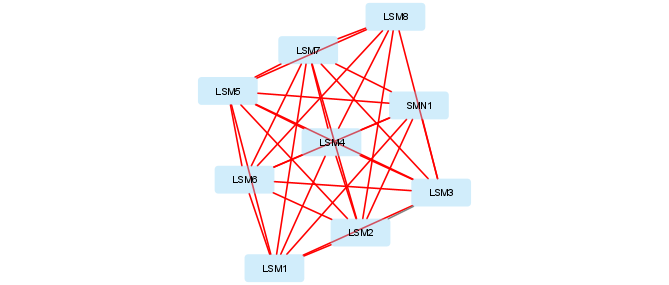

In [9]:
p4c.install_app('MCODE')
p4c.commands_post('mcode cluster network=""')
p4c.commands.commands_post('mcode view id=1 rank=2')

OUT_FILE = 'Cluster.png'
p4c.export_image(OUT_FILE)
p4c.sandbox_get_from(OUT_FILE, f'{OUTPUT_DIR}{OUT_FILE}')

from IPython.display import Image, display
display(Image(filename=f'{OUTPUT_DIR}{OUT_FILE}'))

---
# Explore the human disease network

First, load the disease network into Cytoscape.

Note that the delimiter between values is " "

In [11]:
p4c.close_session(False)
p4c.import_network_from_file('disease.net.txt', tabular_params={'firstRowAsColumnNames': True, 'startLoadRow': 1, 'columnTypeList': 's,t,ea', 'delimiters': ' '})



{'networks': [475647], 'views': [487445]}

There are lots of duplicate edges, so remove duplicates.

Note that we'd prefer to use delete_duplicate_edges() for this, but it doesn't work for this case. I suspect it's because it doesn't offer a distinction between directional and non-directional edges.

Better to extend CyREST to expose duplicate edge deletion.

TODO: get this fixed.

**NOTE:** This is tracked as CYTOSCAPE-12767 ... when it's fixed, verify it in this code

In [ ]:
#p4c.delete_duplicate_edges()
input('Execute Edit | Remove Duplicate Edges manually ... select "disease.net.txt" ... check "Ignore edge direction"')

Execute Edit | Remove Duplicate Edges manually ... select "disease.net.txt" ... check "Ignore edge direction"


''

## Annotate network with S2 table values

Use Pandas to parse the data because we need to rename the 'name' column to 'Disease Name' to avoid conflicts with the network's existing 'name' column.

Once that is done, we can import the annotations into the node table, keyed on the 'Disease ID' column. Note that Pandas would naturally import Disease ID as an int, but we coerce it to str to be compatible with the network's 'name' column.

In [12]:
p4c.sandbox_get_from('supplementary_tableS2.txt', 'Barabasi/supplementary_tableS2.txt')
import pandas as df
disease_table = df.read_csv('Barabasi/supplementary_tableS2.txt', sep='\t', header=1, dtype={'Disease ID':str})
disease_table.rename({'Name': 'Disease Name'}, axis=1, inplace=True)
disease_table

,Disease ID,Disease Name,Disorder class,Size (s),Degree (k),Class-degree (k),Genes implicated (Entrez ID) [comma-deliminated]
0,1,"17,20-lyase_deficiency",Endocrine,1,0,0,CYP17A1 (1586)
1,3,2-methyl-3-hydroxybutyryl-CoA_dehydrogenase_de...,Metabolic,1,0,0,HADH2 (3028)
2,4,2-methylbutyrylglycinuria,Metabolic,1,0,0,ACADSB (36)
3,5,"3-beta-hydroxysteroid_dehydrogenase,_type_II,_...",Metabolic,1,0,0,HSD3B2 (3284)
4,6,3-hydroxyacyl-CoA_dehydrogenase_deficiency,Metabolic,1,0,0,HADHSC (3033)
...,...,...,...,...,...,...,...
1279,8350,Combined_SAP_deficiency,Metabolic,1,2,2,PSAP (5660)
1280,9037,Multiple_myeloma,Cancer,2,1,0,"IRF4 (3662), LIG4 (3981)"
1281,9038,Multiple_sclerosis,Neurological,2,3,2,"CIITA (4261), PTPRC (5788)"
1282,9039,Multiple_sulfatase_deficiency,Metabolic,1,0,0,SUMF1 (285362)


In [13]:
p4c.load_table_data(disease_table, data_key_column='Disease ID')

/usr/local/lib/python3.7/dist-packages/py4cytoscape/tables.py:470: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset[col] = col_val


'Success: Data loaded in defaultnode table'

## Search for and select all nodes that have any attribute having to do with Neuro.

Create a filter that identifies the term `Neuro` in each description column, then create a composite filter that selects all nodes that match either filter.

In [16]:
p4c.create_column_filter('Find Neuro in Name', 'Disease Name', 'Neuro', 'CONTAINS', apply=False)
p4c.create_column_filter('Find Neuro in class', 'Disorder class', 'Neuro', 'CONTAINS', apply=False)
p4c.create_composite_filter('Find Neuro', ['Find Neuro in Name', 'Find Neuro in class'], type='ANY')

No edges selected.


{'edges': None,
 'nodes': ['942',
  '908',
  '807',
  '461',
  '1196',
  '811',
  '1057',
  '1055',
  '817',
  '1097',
  '990',
  '1095',
  '1096',
  '891',
  '1171',
  '1198',
  '4291',
  '1200',
  '734',
  '984',
  '497',
  '289',
  '1091',
  '656',
  '1396',
  '1428',
  '1192',
  '291',
  '676',
  '1456',
  '296',
  '295',
  '301',
  '1099',
  '56',
  '1307',
  '57',
  '318',
  '103',
  '996',
  '1117',
  '877',
  '1376',
  '86',
  '96',
  '98',
  '1013',
  '1093',
  '412',
  '1225',
  '102',
  '1092',
  '913',
  '104',
  '1261',
  '1418',
  '359',
  '2385',
  '1253',
  '1321',
  '733',
  '3260',
  '1007',
  '226',
  '712',
  '581',
  '388',
  '708',
  '1263',
  '988',
  '1440',
  '725',
  '4188',
  '1022',
  '829',
  '985',
  '495',
  '154',
  '162',
  '220',
  '1462',
  '1174',
  '1476',
  '462',
  '9038',
  '1098']}

## Randomly assign colors to each disease

TODO: Figure out how to do mapping value generator to randomly assign colors for node Fill Color

**NOTE:** This is tracked as CSD-437. When it's fixed, use it here.

## Create edge widths according to the number of neighbors

TODO: Figure out how to do mapping value generator to assign a number series for edge width


**NOTE:** This is tracked as CSD-437. When it's fixed, use it here.

## Show the resulting network for fun

## Change node label to be disease name instead of disease number

In [17]:
node_label_map = p4c.map_visual_property('NODE_LABEL', 'Disease Name', 'passthrough')
p4c.update_style_mapping('default', node_label_map)


''

## Set node width and height to be proportional to Degree (k) column value

In [18]:
node_height_map = p4c.map_visual_property('NODE_HEIGHT', 'Degree (k)', 'continuous', [1, 50], [30, 300])
p4c.update_style_mapping('default', node_height_map)
node_width_map = p4c.map_visual_property('NODE_WIDTH', 'Degree (k)', 'continuous', [1, 50], [30, 300])
p4c.update_style_mapping('default', node_width_map)

''

## Toss all disconnected sub-networks

We start by identifying a node in the main network ... I chose node 812, which is Insomnia. Next, we keep finding new neighbors until there are no more new neighbors. The only nodes left out will be the disconnected ones.

Next, we delete the disconnected nodes and re-size the network to fill the drawing space.

In [19]:
select_list = p4c.select_nodes(['812'], by_col='name', preserve_current_selection=False)['nodes']

new_select_list = p4c.select_first_neighbors()['nodes']
while len(select_list) != len(new_select_list):
  select_list = new_select_list
  new_select_list = p4c.select_first_neighbors()['nodes']

p4c.invert_node_selection()
p4c.delete_selected_nodes()
p4c.fit_content()



{}

## Display the network, just for fun

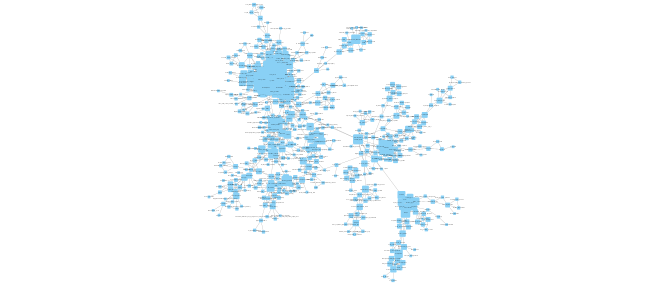

In [20]:
OUT_FILE = 'Disease.png'
p4c.export_image(OUT_FILE)
p4c.sandbox_get_from(OUT_FILE, f'{OUTPUT_DIR}{OUT_FILE}')

from IPython.display import Image, display
display(Image(filename=f'{OUTPUT_DIR}{OUT_FILE}'))